In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df = pd.read_excel("/content/Talent_Academy_Case_DT_2025.xlsx")

#**Veri Setinin Null-Eksik-NaN Değer Analizi**



In [96]:
df.isnull().sum()

,0
HastaNo,0
Yas,0
Cinsiyet,169
KanGrubu,675
Uyruk,0
KronikHastalik,611
Bolum,11
Alerji,944
Tanilar,75
TedaviAdi,0


#**Tedavi Süresi ve Uygulama Süresi Sütunlarının Numerikleştirilmesi**

In [103]:
df["TedaviSuresi"] = df["TedaviSuresi"].str.extract(r'(\d+)').astype(int)
df.rename(columns={"TedaviSuresi": "TedaviSuresi_Seans"}, inplace=True)

In [104]:
df["UygulamaSuresi"] = df["UygulamaSuresi"].str.extract(r'(\d+)').astype(int)
df.rename(columns={"UygulamaSuresi": "UygulamaSuresi_Dakika"}, inplace=True)

#**Boş Alerji Sütunlarının Bilinmiyor Olarak İşlenmesi - Tekrarlı İfadelerin/Hatalı Yazımların Düzeltilmesi**

In [105]:
df["Alerji"] = df["Alerji"].fillna("Bilinmiyor")

In [106]:
df["Alerji"] = df["Alerji"].str.title()

In [107]:
df["Alerji"] = df["Alerji"].apply(lambda x: [i.strip().lower() for i in str(x).split(",")])

In [108]:
corrections = {'gri̇pi̇n': 'gripin','gripin': 'gripin','volteren': 'voltaren','voltaren': 'voltaren'}

In [109]:
def normalize_allergen(x):
    import re

    if isinstance(x, list):
        x = ','.join(x)

    if not x or pd.isna(x):
        return 'bilinmiyor'

    x = re.sub(r'[\[\]]', '', str(x))

    items = [i.strip().lower() for i in x.split(',')]

    items = [corrections.get(i, i) for i in items]

    items = sorted(list(set(items)))

    return ', '.join(items)


In [110]:
df['Alerji_normalized'] = df['Alerji'].apply(normalize_allergen)

In [111]:
df = df.drop(columns=['Alerji'])
df = df.rename(columns={'Alerji_normalized': 'Alerji'})

# **Alerji Sütununun Encode Edilmesi**




In [112]:
df['Alerji_list'] = df['Alerji'].apply(lambda x: [i.strip() for i in x.split(',')])

from itertools import chain
unique_allergens = sorted(set(chain.from_iterable(df['Alerji_list'])))

for allergen in unique_allergens:
    df[allergen] = df['Alerji_list'].apply(lambda x: 1 if allergen in x else 0)

df = df.drop(columns=['Alerji_list'])


In [113]:
pd.set_option('display.max_columns', None)

# **Görselleştirme - Grafik İşlemleri**

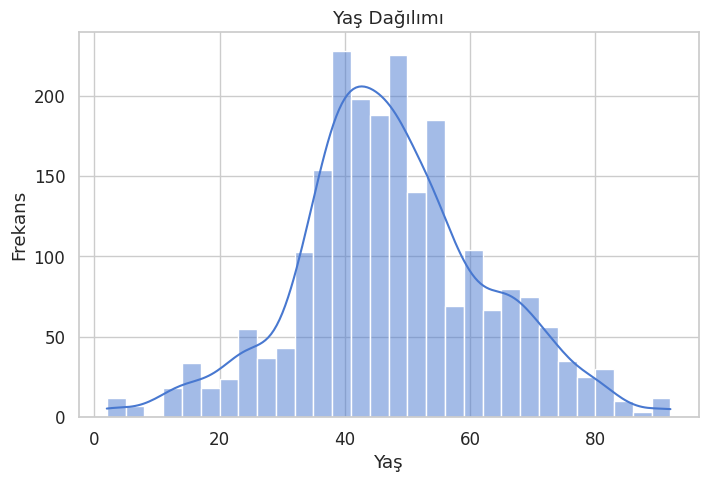

In [116]:
# Daha güzel görünüm için stil
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 1. YAŞ DAĞILIMI (Histogram + KDE)
plt.figure(figsize=(8,5))
sns.histplot(df["Yas"], bins=30, kde=True)
plt.title("Yaş Dağılımı")
plt.xlabel("Yaş")
plt.ylabel("Frekans")
plt.show()


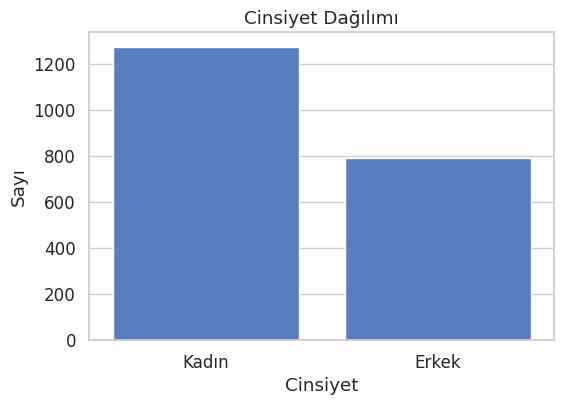

In [117]:
# 2. CİNSİYET DAĞILIMI (Countplot)
plt.figure(figsize=(6,4))
sns.countplot(x="Cinsiyet", data=df)
plt.title("Cinsiyet Dağılımı")
plt.xlabel("Cinsiyet")
plt.ylabel("Sayı")
plt.show()

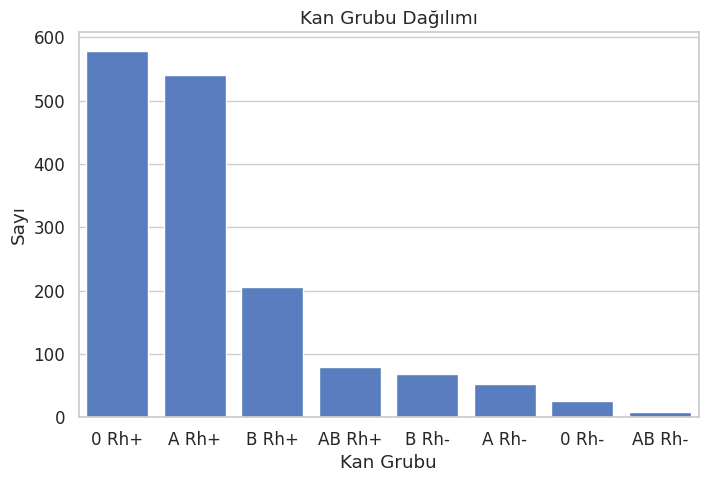

In [118]:
# 3. KAN GRUBU DAĞILIMI
plt.figure(figsize=(8,5))
sns.countplot(x="KanGrubu", data=df, order=df["KanGrubu"].value_counts().index)
plt.title("Kan Grubu Dağılımı")
plt.xlabel("Kan Grubu")
plt.ylabel("Sayı")
plt.show()

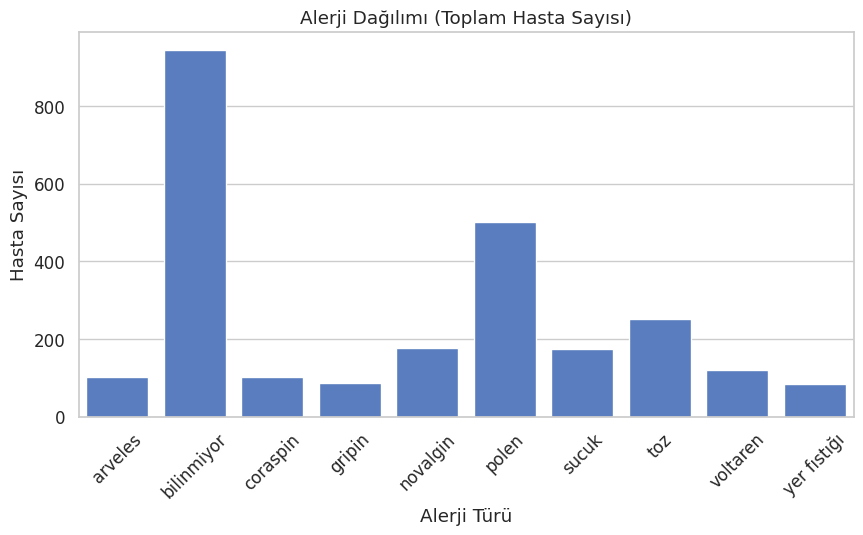

In [119]:
# 4. ALERJİLERİN DAĞILIMI (One-Hot encoding sonrası)
alerji_cols = ["arveles","bilinmiyor","coraspin","gripin",
               "novalgin","polen","sucuk","toz","voltaren","yer fıstığı"]

plt.figure(figsize=(10,5))
sns.barplot(x=df[alerji_cols].sum().index, y=df[alerji_cols].sum().values)
plt.title("Alerji Dağılımı (Toplam Hasta Sayısı)")
plt.xlabel("Alerji Türü")
plt.ylabel("Hasta Sayısı")
plt.xticks(rotation=45)
plt.show()

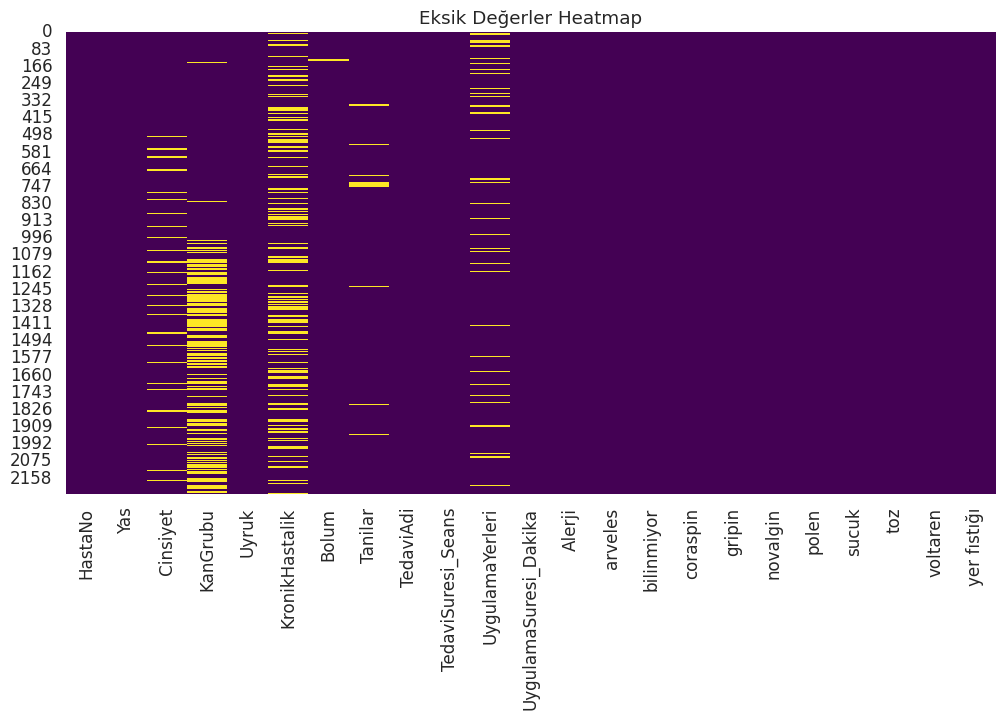

In [120]:
# 5. EKSİK DEĞERLER (Heatmap)
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, cmap="viridis")
plt.title("Eksik Değerler Heatmap")
plt.show()

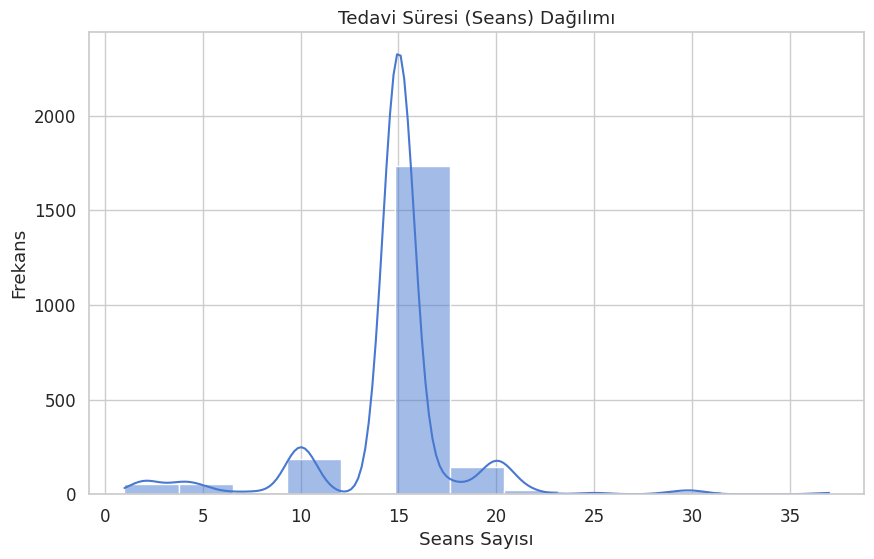

In [124]:
#Tedavi Süresi Dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='TedaviSuresi_Seans', kde=True)
plt.title('Tedavi Süresi (Seans) Dağılımı')
plt.xlabel('Seans Sayısı')
plt.ylabel('Frekans')
plt.show()

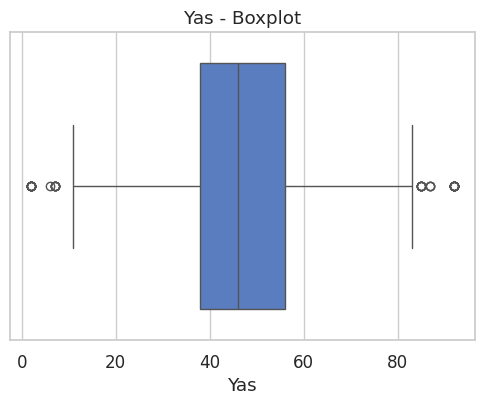

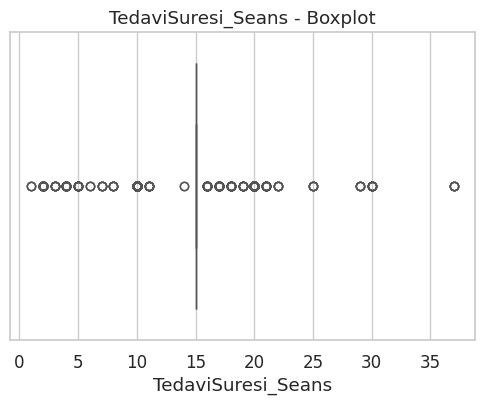

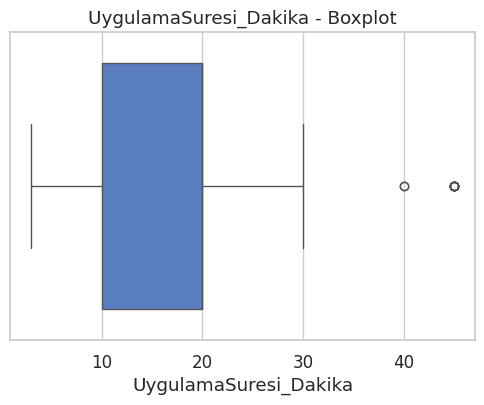

In [128]:
# Sayısal sütunlarda boxplot
num_cols = ["Yas", "TedaviSuresi_Seans", "UygulamaSuresi_Dakika"]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"{col} - Boxplot")
    plt.show()

# IQR ile uç değerleri işaretleme
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]

In [122]:
from scipy.stats import pointbiserialr

# sadece alerji sütunlarını seçelim (0/1)
alerji_cols = ["arveles", "bilinmiyor", "coraspin", "gripin", "novalgin",
               "polen", "sucuk", "toz", "voltaren", "yer fıstığı"]

sonuclar = {}
for col in alerji_cols:
    corr, pval = pointbiserialr(df["Yas"], df[col])
    sonuclar[col] = {"Korelasyon": corr, "p-değeri": pval}

import pandas as pd
sonuclar_df = pd.DataFrame(sonuclar).T
print(sonuclar_df)

             Korelasyon  p-değeri
arveles       -0.101569  0.000001
bilinmiyor    -0.015653  0.459510
coraspin      -0.101569  0.000001
gripin         0.002061  0.922436
novalgin       0.011998  0.570761
polen          0.031314  0.138898
sucuk          0.025818  0.222427
toz           -0.003993  0.850364
voltaren       0.024632  0.244417
yer fıstığı    0.033590  0.112391


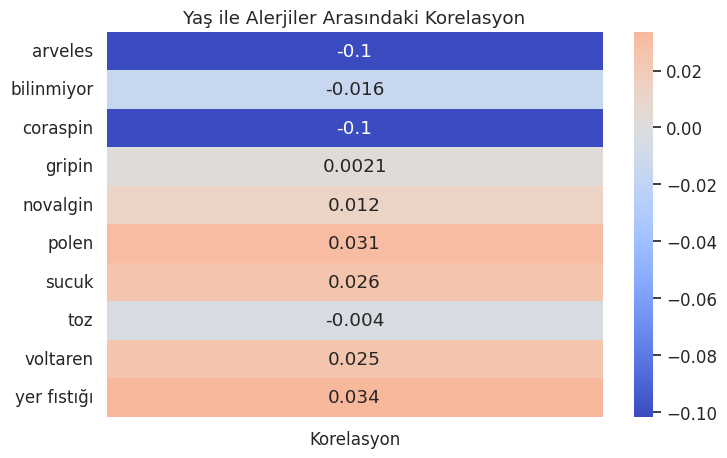

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(sonuclar_df[["Korelasyon"]], annot=True, cmap="coolwarm", center=0)
plt.title("Yaş ile Alerjiler Arasındaki Korelasyon")
plt.show()


In [ ]:
from scipy.stats import pearsonr, spearmanr

# Pearson
pearson_corr, pearson_p = pearsonr(df["Yas"], df["TedaviSuresi_Seans"])

# Spearman (monotonik ilişki için)
spearman_corr, spearman_p = spearmanr(df["Yas"], df["TedaviSuresi_Seans"])

print("Pearson Korelasyon:", pearson_corr, " | p-değeri:", pearson_p)
print("Spearman Korelasyon:", spearman_corr, " | p-değeri:", spearman_p)


Pearson Korelasyon: -0.013252078519818938  | p-değeri: 0.5311972461124649
Spearman Korelasyon: -0.01832601345052056  | p-değeri: 0.3865094967818301


In [ ]:
from scipy.stats import pearsonr, spearmanr

# Pearson
pearson_corr, pearson_p = pearsonr(df["Yas"], df["UygulamaSuresi_Dakika"])

# Spearman
spearman_corr, spearman_p = spearmanr(df["Yas"], df["UygulamaSuresi_Dakika"])

print("Pearson Korelasyon:", pearson_corr, "| p-değeri:", pearson_p)
print("Spearman Korelasyon:", spearman_corr, "| p-değeri:", spearman_p)


Pearson Korelasyon: 0.00024426357085031167 | p-değeri: 0.9907915853412087
Spearman Korelasyon: 0.01191877645355743 | p-değeri: 0.5733161917896861


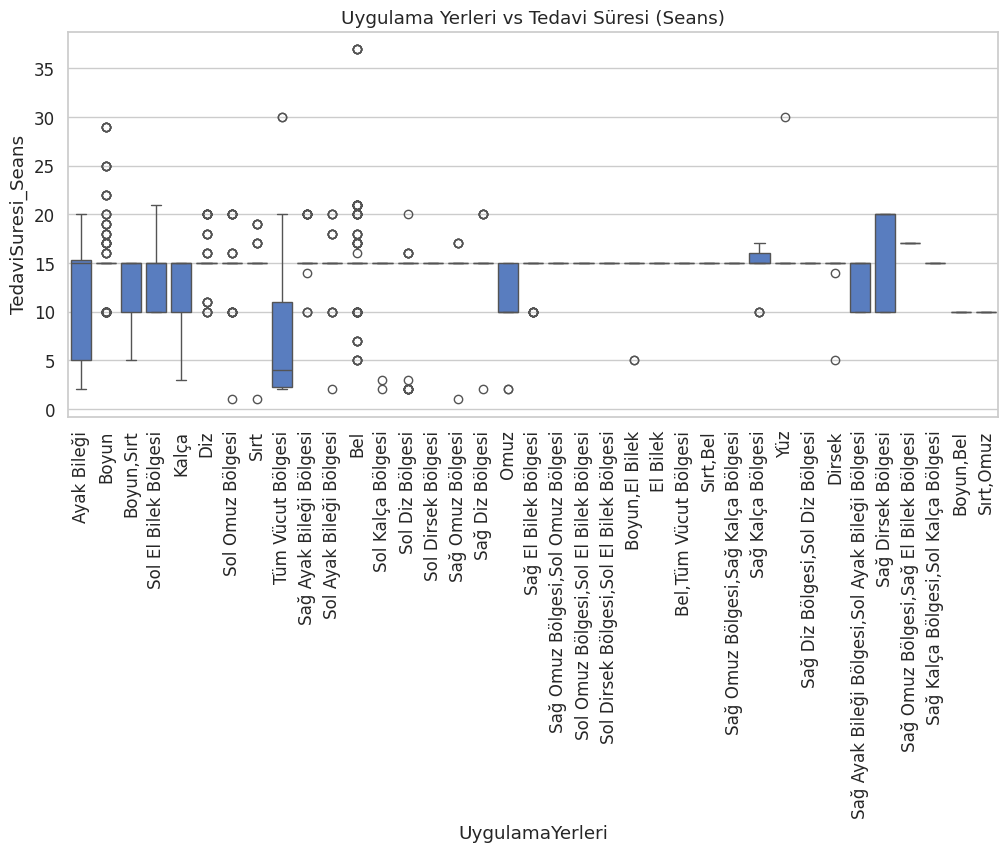

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x="UygulamaYerleri", y="TedaviSuresi_Seans", data=df)
plt.xticks(rotation=90)
plt.title("Uygulama Yerleri vs Tedavi Süresi (Seans)")
plt.show()

# **UygulamaYerleri Sütununun Düzenlenmesi, Tekrarlı İfadelerin, Hatalı Yazımların Düzeltilmesi ve Standardizasyonu**



In [47]:
df['UygulamaYerleri'] = df['UygulamaYerleri'].str.lower()


In [49]:

replace_map = {
    'sol omuz bölgesi':'omuz-sol',
    'sağ omuz bölgesi':'omuz-sağ',
    'omuz':'omuz-genel',
    'sol el bilek bölgesi':'elbilek-sol',
    'sağ el bilek bölgesi':'elbilek-sağ',
    'el bilek':'elbilek-genel',
    'sol ayak bileği bölgesi':'ayakbilek-sol',
    'sağ ayak bileği bölgesi':'ayakbilek-sağ',
    'ayak bileği':'ayakbilek-genel',
    'sol kalça bölgesi':'kalça-sol',
    'sağ kalça bölgesi':'kalça-sağ',
    'kalça':'kalça-genel',
    'sol diz bölgesi':'diz-sol',
    'sağ diz bölgesi':'diz-sağ',
    'diz':'diz',
    'dirsek':'dirsek',
    'sol dirsek bölgesi':'dirsek-sol',
    'sağ dirsek bölgesi':'dirsek-sağ',
    'tüm vücut bölgesi':'tum_vucut',
    'bel':'bel',
    'boyun':'boyun',
    'sırt':'sırt',
    'sirt':'sırt',
    'yüz':'yüz',
}

def normalize_cell(cell):
    if pd.isna(cell):   # NaN kontrolü
        return cell
    parts = [p.strip() for p in str(cell).split(",")]
    return ", ".join(replace_map.get(p, p) for p in parts)

df["UygulamaYerleri"] = df["UygulamaYerleri"].apply(normalize_cell)

# **Virgülle Ayrılan Çoklu Değerlerin Düzenlenmesi, Encoding**

In [52]:
from sklearn.preprocessing import MultiLabelBinarizer

df["UygulamaYerleri"] = df["UygulamaYerleri"].apply(
    lambda x: [p.strip() for p in str(x).split(",")] if pd.notna(x) else []
)

mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(df["UygulamaYerleri"])

for col, vals in zip(mlb.classes_, encoded.T):
    df[col] = vals


In [53]:
df["UygulamaYerleri"].value_counts()

,count
UygulamaYerleri,
[bel],528
[boyun],363
[],221
[diz],177
[omuz-sol],137
[omuz-sağ],127
[elbilek-sol],83
[sırt],75
[ayakbilek-sağ],61


# **Cinsiyet ve Kan Grubu Sütunlarının Encoding İşlemi**

In [56]:
df["Cinsiyet"] = df["Cinsiyet"].fillna("Bilinmiyor")
df["KanGrubu"] = df["KanGrubu"].fillna("Bilinmiyor")
df = pd.get_dummies(df, columns=["Cinsiyet", "KanGrubu"], prefix=["cinsiyet", "kangrubu"])

In [ ]:
df["Bolum"].value_counts(dropna=False)

,count
Bolum,
"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",2045
Ortopedi Ve Travmatoloji,88
İç Hastalıkları,32
Nöroloji,17
Kardiyoloji,11
NaN,11
Göğüs Hastalıkları,8
Laboratuar,7
Genel Cerrahi,6


# **Bölüm Sütununun TedaviSüresi Hedef Değişkenine Göre Ortalama Değerlerinin Bulunması ve Düşük Ortalamadaki Değerlerin "Diğer" Sınıfında Ayrıştırılması**

In [ ]:
df.groupby('Bolum')['TedaviSuresi_Seans'].mean()

,TedaviSuresi_Seans
Bolum,
"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",15.136430
Genel Cerrahi,9.833333
Göğüs Hastalıkları,13.125000
Kalp Ve Damar Cerrahisi,11.000000
Kardiyoloji,11.363636
Laboratuar,9.857143
Nöroloji,10.000000
Ortopedi Ve Travmatoloji,4.818182
Tıbbi Onkoloji,9.000000


In [58]:
df['Bolum'] = df['Bolum'].apply(lambda x: 'Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi' if x == 'Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi' else ('Bilinmiyor' if pd.isna(x) else 'Diğer'))


In [59]:
df["Bolum"].value_counts(dropna=False)

,count
Bolum,
"Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",2045
Diğer,179
Bilinmiyor,11


# **TedaviAdi Sütununun Normalizasyon İşlemleri**

In [64]:
df['TedaviAdi'].unique()

array(['Ayak Bileği', 'Dorsalji -Boyun+trapez+skapular', 'Parapleji',
       'El rehabilitasyonu', 'El rehabilitasyonu-El Rehabilitasyonu',
       'kalça ağrısı+trokanterik bursit', 'Gonartroz-Meniskopati',
       'Sol Omuz impingement', 'Sol Omuz İmpingement',
       'Dorsalji -Boyun+trapez', 'Lenfödem+ekstremite ağrısı',
       'Alt ekstremite atrofi-Bilateral', 'Aşil Rüptürü-1',
       'Aşil Rüptürü-2', 'aşil ameliyatı erken',
       'Dorsalji +Servikal Myelomalazi', 'SOL KALÇA İMPLANTI',
       'Dorsalji 1', 'Koksartroz1', 'Sağ subtrokanterik kırık',
       'Boyun-Trapezz', 'MENİSKÜS TAMİRİ ', 'Diz Menisküs, ',
       'İV DİSK BOZUKLUĞU-BEL', 'Yürüme', 'Parapleji-Tetrapleji',
       'Dorsalji-Bel+ Eklem ağrsıı', 'Dorsalji',
       'Alt ekstremite atrofi+yürüme', 'Spinal Stenoz',
       'Sol diz Post Op-Geç Dönme', 'Humerus alt uş-Dirsek kırığı',
       'Dorsalji-Bel', 'Sağ+ sol humerus kırığı ', 'Humerus kırığı',
       'Bel FTR', 'Sol Diz Eklem İmplantı', 'Kondromalezi patella-1',

In [67]:
import re
import unicodedata

def normalize_text(text):
    if pd.isna(text):
        return "eksik"

    text = text.lower()

    text = unicodedata.normalize("NFKC", text)

    text = re.sub(r"[-+/,.;:]", " ", text)

    text = re.sub(r"\s+", " ", text).strip()


    return text


In [68]:
df["TedaviAdi_norm"] = df["TedaviAdi"].apply(normalize_text)

In [70]:
df["TedaviAdi_norm"].unique()

array(['ayak bileği', 'dorsalji boyun trapez skapular', 'parapleji',
       'el rehabilitasyonu', 'el rehabilitasyonu el rehabilitasyonu',
       'kalça ağrısı trokanterik bursit', 'gonartroz meniskopati',
       'sol omuz impingement', 'sol omuz i̇mpingement',
       'dorsalji boyun trapez', 'lenfödem ekstremite ağrısı',
       'alt ekstremite atrofi bilateral', 'aşil rüptürü 1',
       'aşil rüptürü 2', 'aşil ameliyatı erken',
       'dorsalji servikal myelomalazi', 'sol kalça i̇mplanti',
       'dorsalji 1', 'koksartroz1', 'sağ subtrokanterik kırık',
       'boyun trapezz', 'meni̇sküs tami̇ri̇', 'diz menisküs',
       'i̇v di̇sk bozukluğu bel', 'yürüme', 'parapleji tetrapleji',
       'dorsalji bel eklem ağrsıı', 'dorsalji',
       'alt ekstremite atrofi yürüme', 'spinal stenoz',
       'sol diz post op geç dönme', 'humerus alt uş dirsek kırığı',
       'dorsalji bel', 'sağ sol humerus kırığı', 'humerus kırığı',
       'bel ftr', 'sol diz eklem i̇mplantı', 'kondromalezi patella 1',


In [72]:
import pandas as pd
import numpy as np

replace_map = {
    'omurga': [
        'boyun', 'bel', 'sırt', 'dorsalji', 'servikal', 'disk', 'hernisi',
        'stenoz', 'radikülopati', 'kifoz', 'skolyoz', 'koksiks'
    ],
    'omuz_kol': [
        'omuz', 'humerus', 'dirsek', 'epikondilit', 'triseps', 'teres', 'skapular'
    ],
    'alt_ekstremite': [
        'diz', 'gonartroz', 'menisküs', 'meniskopati', 'patella', 'kalça', 'koksartroz',
        'ayak', 'aşil', 'plantar', 'fasiit', 'malleol', 'femur', 'fibula', 'trokanterik'
    ],
    'üst_ekstremite': [
        'el', 'bilek', 'parmak', 'metakarp', 'metkarp', 'tfcc', 'volar', 'tendon'
    ],
    'nörolojik': [
        'hemipleji', 'hemiparezi', 'parapleji', 'tetrapleji',
        'serebral', 'travmatik beyin', 'fasiyal', 'ataksi',
        'organ nakli', 'beyin', 'hemartrotik'
    ],
    'genel': [
        'rehabilitasyon', 'yürüme', 'kuvvetsizlik', 'eklem ağrısı',
        'pelvik', 'pilates', 'deneme', 'xx', 'onur', 'programı'
    ]
}

def map_tedavi(text):
    if pd.isna(text):
        return ['eksik']
    categories = []
    for cat, keywords in replace_map.items():
        for kw in keywords:
            if kw in text:
                categories.append(cat)
                break
    if not categories:
        categories = ['genel']
    return categories

df['Tedavi_Kategori'] = df['TedaviAdi_norm'].apply(map_tedavi)


# **TedaviAdi Sütunundaki Verilerin Kategorizasyona Uygun Hale Getirilmesi Ve Encoding İşlemi**

In [73]:
df['Tedavi_Kategori'].value_counts()

,count
Tedavi_Kategori,
[omurga],614
[alt_ekstremite],388
"[omurga, üst_ekstremite]",380
[genel],287
[omuz_kol],268
[üst_ekstremite],68
[nörolojik],62
"[alt_ekstremite, üst_ekstremite]",49
"[üst_ekstremite, genel]",47


In [74]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(df['Tedavi_Kategori'])

encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)

df = pd.concat([df, encoded_df], axis=1)


In [75]:
df.head()

,HastaNo,Yas,Uyruk,KronikHastalik,Bolum,Tanilar,TedaviAdi,TedaviSuresi_Seans,UygulamaYerleri,UygulamaSuresi_Dakika,Alerji,arveles,bilinmiyor,coraspin,gripin,novalgin,polen,sucuk,toz,voltaren,yer fıstığı,ayakbilek-genel,ayakbilek-sağ,ayakbilek-sol,bel,boyun,dirsek,dirsek-sağ,dirsek-sol,diz,diz-sağ,diz-sol,elbilek-genel,elbilek-sağ,elbilek-sol,kalça-genel,kalça-sağ,kalça-sol,omuz-genel,omuz-sağ,omuz-sol,sırt,tum_vucut,yüz,cinsiyet_Bilinmiyor,cinsiyet_Erkek,cinsiyet_Kadın,kangrubu_0 Rh+,kangrubu_0 Rh-,kangrubu_A Rh+,kangrubu_A Rh-,kangrubu_AB Rh+,kangrubu_AB Rh-,kangrubu_B Rh+,kangrubu_B Rh-,kangrubu_Bilinmiyor,TedaviAdi_norm,Tedavi_Kategori,alt_ekstremite,genel,nörolojik,omurga,omuz_kol,üst_ekstremite
0,145134,60,Türkiye,"Becker Musküler Distrofisi, Hiportiroidizm, Ka...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi",Ayak bileği ve ayağın yüzeysel yaralanması,Ayak Bileği,5,[ayakbilek-genel],20,toz,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,True,False,False,False,False,False,False,False,False,ayak bileği,[alt_ekstremite],1,0,0,0,0,0
1,145135,28,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi","Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15,[boyun],20,bilinmiyor,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,True,False,False,False,False,False,False,False,False,dorsalji boyun trapez skapular,"[omurga, omuz_kol]",0,0,0,1,1,0
2,145135,28,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi","Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15,"[boyun, sırt]",20,bilinmiyor,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False,True,False,True,False,False,False,False,False,False,False,False,dorsalji boyun trapez skapular,"[omurga, omuz_kol]",0,0,0,1,1,0
3,145135,28,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi","Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15,[boyun],5,bilinmiyor,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,True,False,False,False,False,False,False,False,False,dorsalji boyun trapez skapular,"[omurga, omuz_kol]",0,0,0,1,1,0
4,145135,28,Türkiye,"Duchenne Musküler Distrofisi, Myastenia gravis...","Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi","Omuzun darbe sendromu,DORSALJİ, DİĞER, SERVİKO...",Dorsalji -Boyun+trapez+skapular,15,"[boyun, sırt]",20,bilinmiyor,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False,True,False,True,False,False,False,False,False,False,False,False,dorsalji boyun trapez skapular,"[omurga, omuz_kol]",0,0,0,1,1,0


In [77]:
df.columns

Index(['HastaNo', 'Yas', 'Uyruk', 'KronikHastalik', 'Bolum', 'Tanilar',
       'TedaviAdi', 'TedaviSuresi_Seans', 'UygulamaYerleri',
       'UygulamaSuresi_Dakika', 'Alerji', 'arveles', 'bilinmiyor', 'coraspin',
       'gripin', 'novalgin', 'polen', 'sucuk', 'toz', 'voltaren',
       'yer fıstığı', 'ayakbilek-genel', 'ayakbilek-sağ', 'ayakbilek-sol',
       'bel', 'boyun', 'dirsek', 'dirsek-sağ', 'dirsek-sol', 'diz', 'diz-sağ',
       'diz-sol', 'elbilek-genel', 'elbilek-sağ', 'elbilek-sol', 'kalça-genel',
       'kalça-sağ', 'kalça-sol', 'omuz-genel', 'omuz-sağ', 'omuz-sol', 'sırt',
       'tum_vucut', 'yüz', 'cinsiyet_Bilinmiyor', 'cinsiyet_Erkek',
       'cinsiyet_Kadın', 'kangrubu_0 Rh+', 'kangrubu_0 Rh-', 'kangrubu_A Rh+',
       'kangrubu_A Rh-', 'kangrubu_AB Rh+', 'kangrubu_AB Rh-',
       'kangrubu_B Rh+', 'kangrubu_B Rh-', 'kangrubu_Bilinmiyor',
       'TedaviAdi_norm', 'Tedavi_Kategori', 'alt_ekstremite', 'genel',
       'nörolojik', 'omurga', 'omuz_kol', 'üst_ekstremite'],
 

# **Gerekli Görülmeyen, Enocde Edildiği İçin Redundant Hale Gelen Sütunların Drop Edilmesi**

In [83]:
drop_columns = [
    'HastaNo',          # ID, model için gerekli değil
    'Uyruk',            # Model için gerekli değil, hedef değişkenle ilgisiz.
    'Bolum',            # Model için gerekli değil.
    'Tanilar',          # TedaviKategori üzerinden zaten özetlendi.
    'TedaviAdi',        # Encode edildiği için redundant.
    'TedaviAdi_norm',   # Encode edildiği için redundant.
    'Tedavi_Kategori',  # Encode edildiği için redundant.
    'UygulamaYerleri',  # Encode edildiği için redundant.
    'Alerji',           # Encode edildiği için redundant.
    'KronikHastalik'    # Hedef değişkenle ilgisiz.
    ]

df = df.drop(columns=drop_columns)

In [87]:
df.columns

Index(['Yas', 'TedaviSuresi_Seans', 'UygulamaSuresi_Dakika', 'arveles',
       'bilinmiyor', 'coraspin', 'gripin', 'novalgin', 'polen', 'sucuk', 'toz',
       'voltaren', 'yer fıstığı', 'ayakbilek-genel', 'ayakbilek-sağ',
       'ayakbilek-sol', 'bel', 'boyun', 'dirsek', 'dirsek-sağ', 'dirsek-sol',
       'diz', 'diz-sağ', 'diz-sol', 'elbilek-genel', 'elbilek-sağ',
       'elbilek-sol', 'kalça-genel', 'kalça-sağ', 'kalça-sol', 'omuz-genel',
       'omuz-sağ', 'omuz-sol', 'sırt', 'tum_vucut', 'yüz',
       'cinsiyet_Bilinmiyor', 'cinsiyet_Erkek', 'cinsiyet_Kadın',
       'kangrubu_0 Rh+', 'kangrubu_0 Rh-', 'kangrubu_A Rh+', 'kangrubu_A Rh-',
       'kangrubu_AB Rh+', 'kangrubu_AB Rh-', 'kangrubu_B Rh+',
       'kangrubu_B Rh-', 'kangrubu_Bilinmiyor', 'alt_ekstremite', 'genel',
       'nörolojik', 'omurga', 'omuz_kol', 'üst_ekstremite'],
      dtype='object')

# **Hatalı-Eksik-NaN Veri Kontrolü**

In [91]:
df.isna().sum()

,0
Yas,0
TedaviSuresi_Seans,0
UygulamaSuresi_Dakika,0
arveles,0
bilinmiyor,0
coraspin,0
gripin,0
novalgin,0
polen,0
sucuk,0


# **Düzenlenen Verilerin Excel'e Kaydedilmesi**

In [92]:
df.to_excel("final.xlsx", index=True)